# Decomposition of sEMG signals from armband

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import os

import numpy as np
import torch

import emgkit
from load_signal_esb import load_signal_esb

logging.basicConfig(level=logging.INFO)

if torch.cuda.is_available:
    device = torch.device("cuda:0")
    logging.info("Using CUDA version")
else:
    device = torch.device("cpu")
    logging.info("Using CPU version")

FS = 4000
SEED = 42
DATA_PATH = os.path.join("data", "esb", "isometric.bin")

INFO:root:Using CUDA version


Load the signal, filter it and plot the power spectrum.

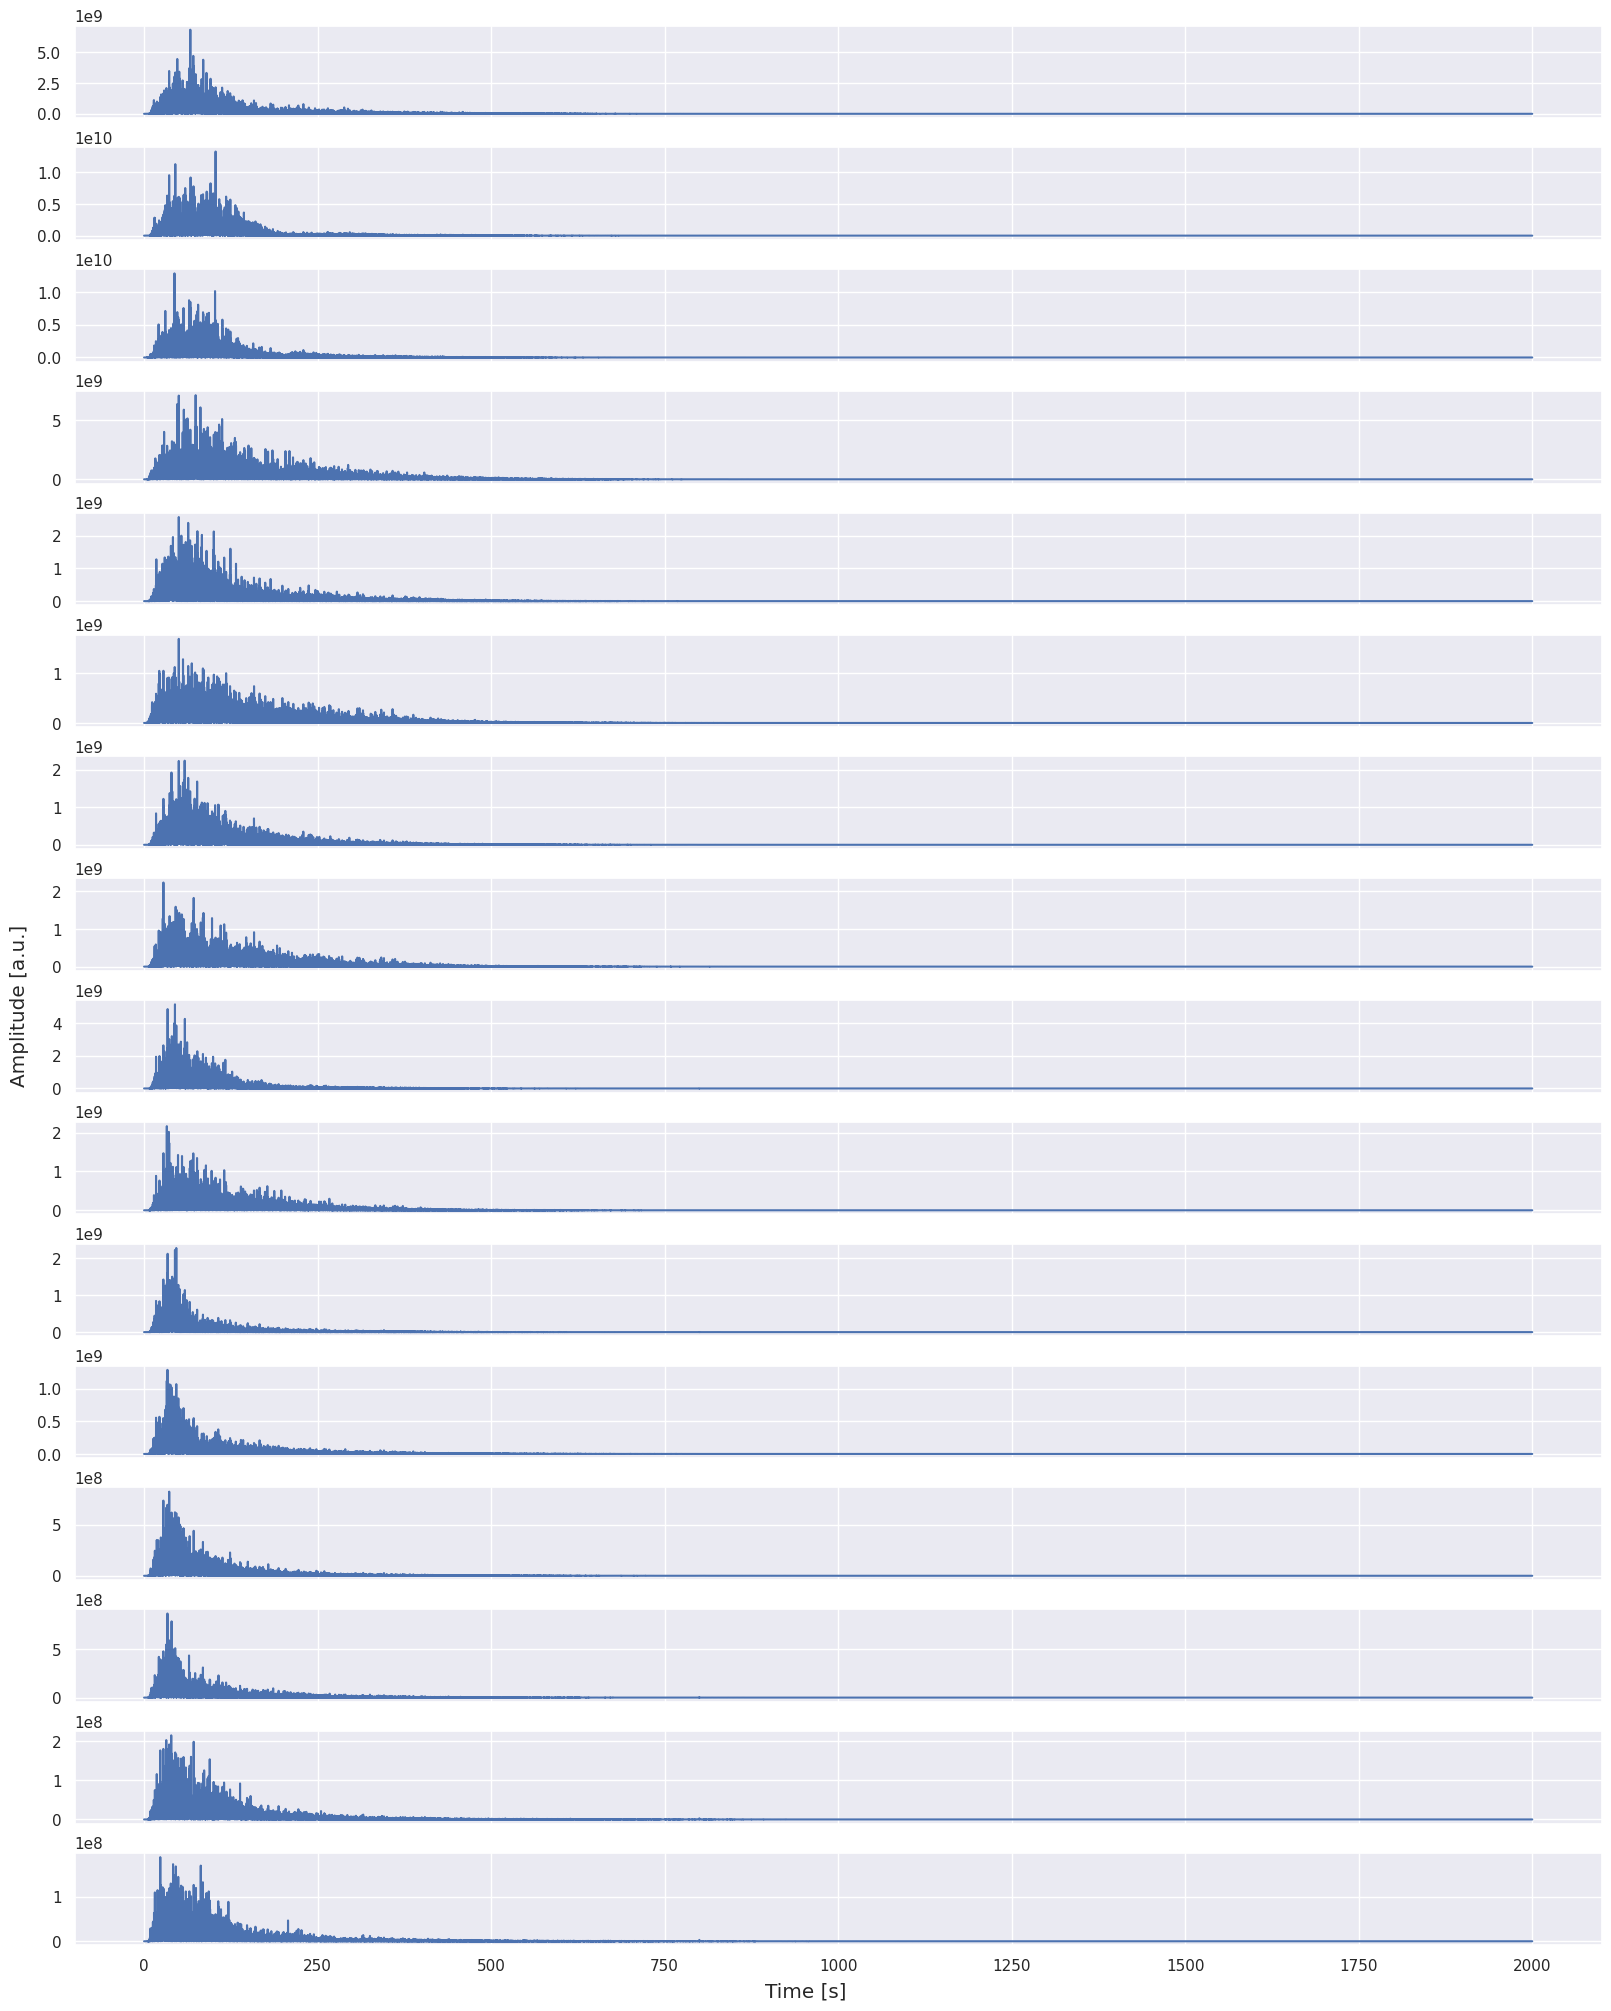

In [2]:
emg = load_signal_esb(DATA_PATH)
labels = emg["Trigger"]
emg = emg.drop(columns="Trigger")
sig_len_s = emg.shape[0] / FS

# Filter
# emg = emgkit.preprocessing.bandstop_filter(emg, low_cut=49, high_cut=51, fs=FS)
emg_flt = emgkit.preprocessing.bandpass_filter(emg, low_cut=10, high_cut=1000, fs=FS)

power_spectrum = emgkit.utils.power_spectrum(emg_flt, FS)
emgkit.plot.plot_signal(power_spectrum, fig_size=(16, 20))

Plot filtered signal and triggers.

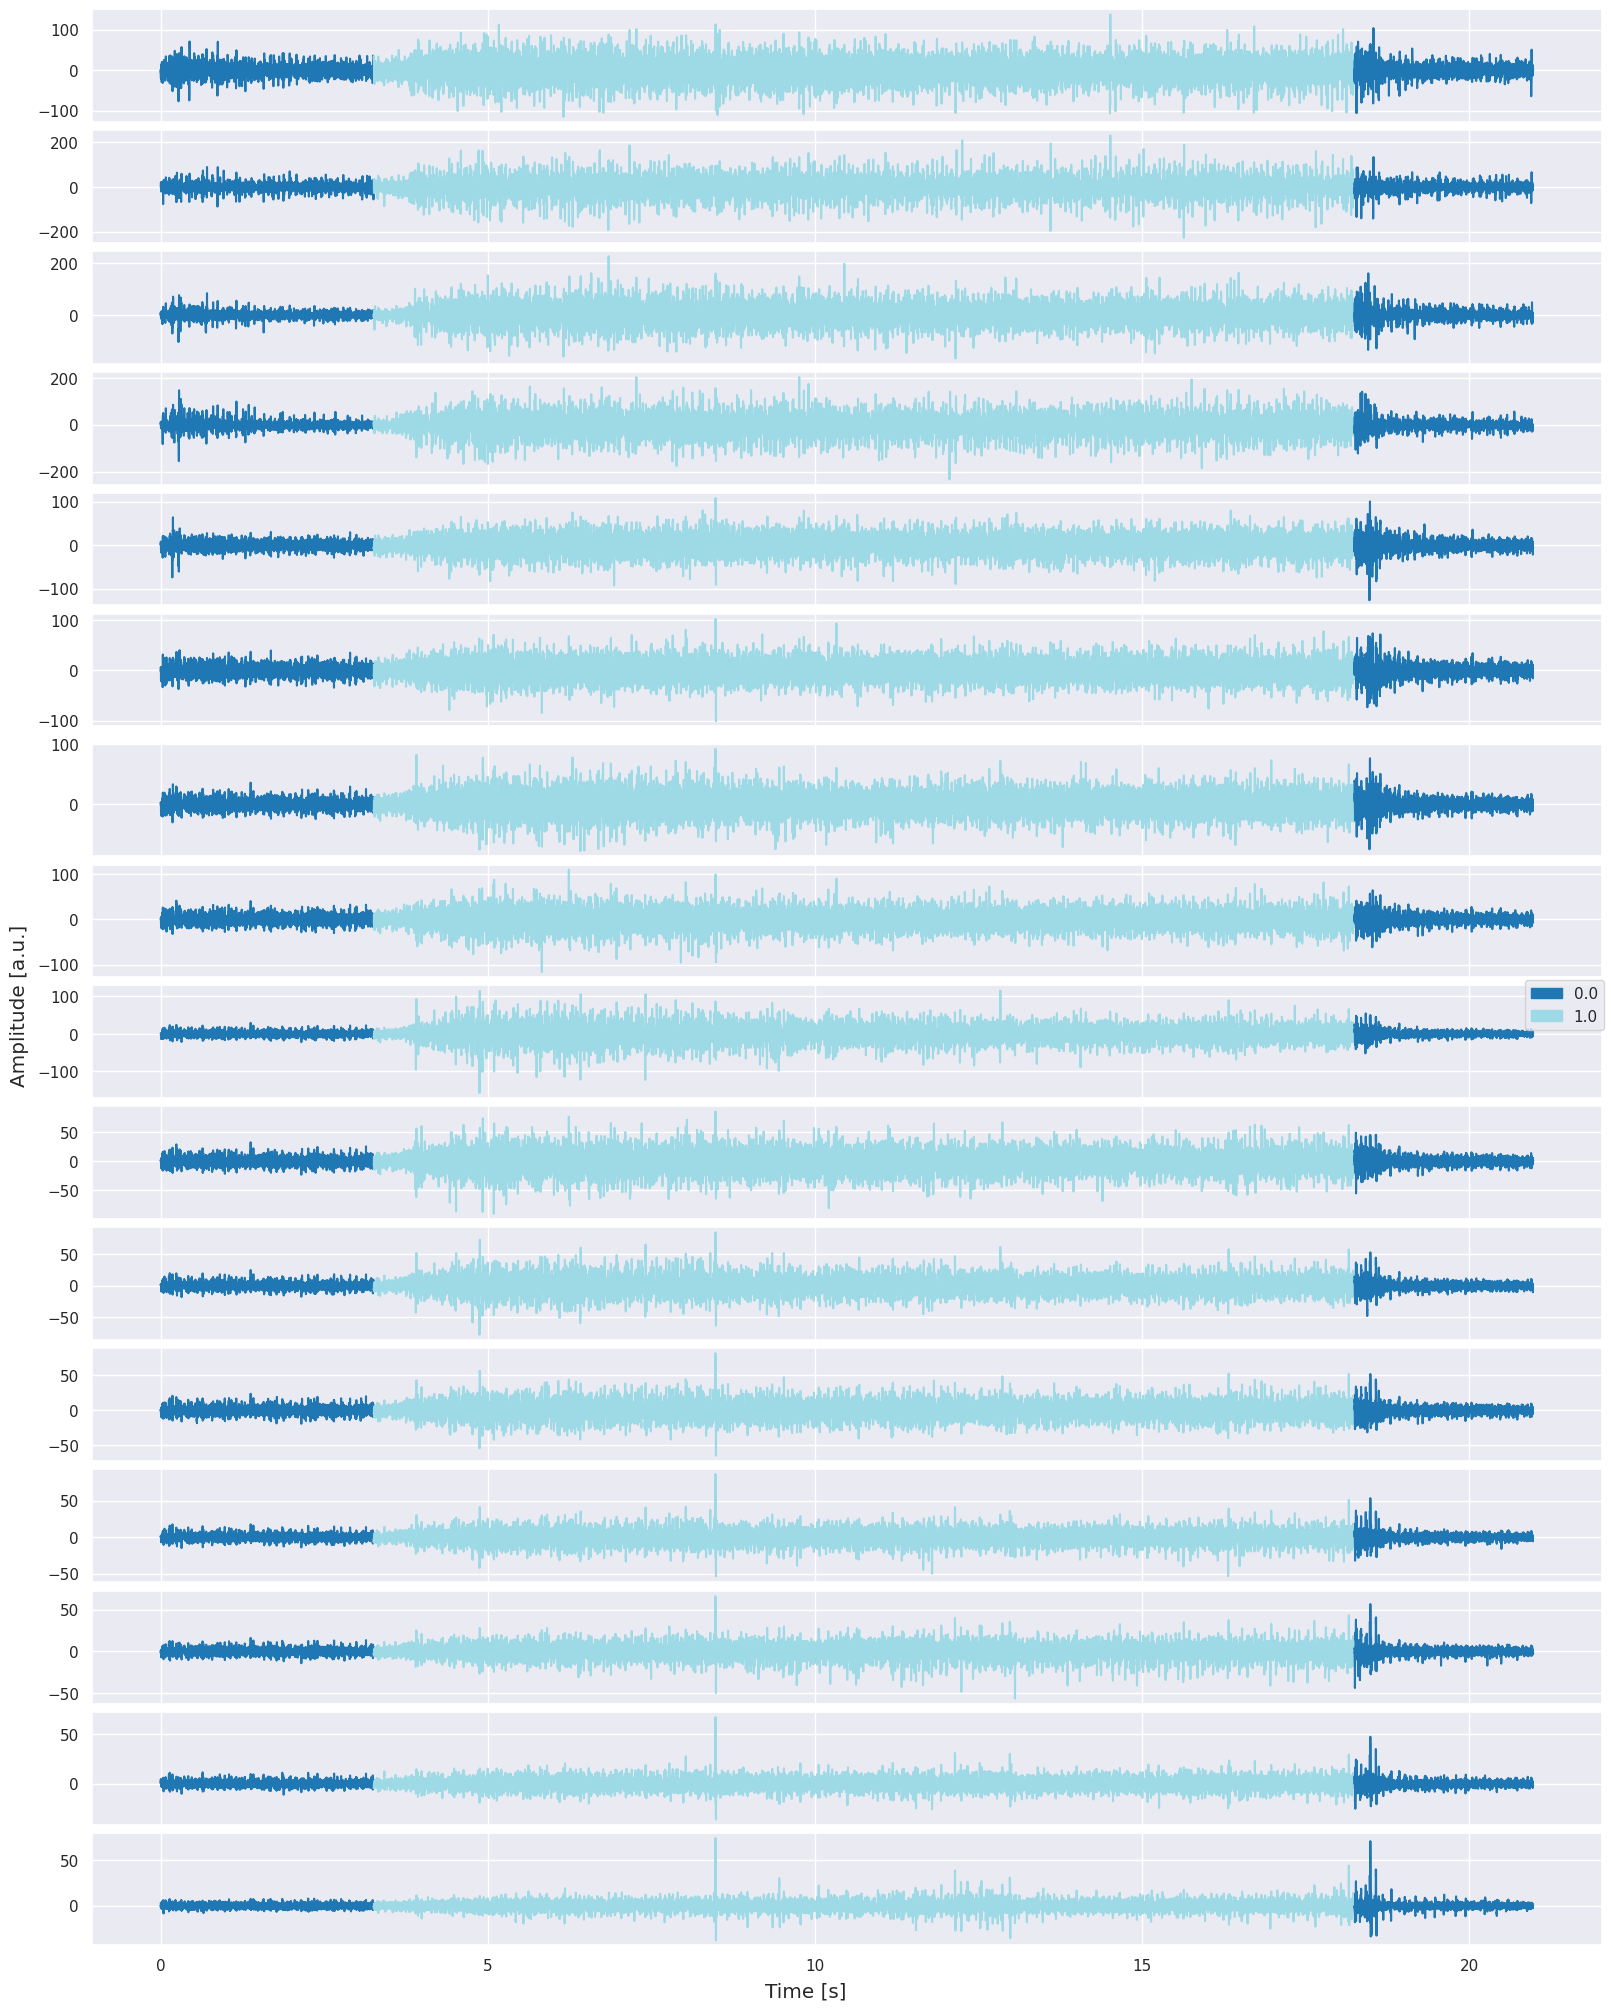

In [3]:
emgkit.plot.plot_signal(emg_flt, FS, labels, fig_size=(16, 20))

Instantiate the decomposition model and perform the MU extraction in the 5--15s range.

In [4]:
emg_bss = emgkit.decomposition.EMGBSS(
    fs=FS,
    f_ext_ms=8.0,
    n_mu_target=150,
    sil_th=0.75,
    device=device,
    seed=SEED,
    whiten_kw={
        "n_pcs": "auto",
        "keep_dim": True,
    },
)

ics, spikes_t = emg_bss.fit_transform(
    emg_flt[int(5 * FS) : int(15 * FS)]  # , [i for i in range(16) if i != 6]]  # exclude channel 7
)
ext_sig_len_s = ics.shape[0] / FS

INFO:root:Number of channels before extension: 16
INFO:root:Number of channels after extension: 512
INFO:root:Instantiating PCAWhitening using "svd" solver.
INFO:root:Reducing dimension of data from 512 to 342.
INFO:root:Re-projecting dimensionality to 512.
INFO:root:----- IC 1 -----
INFO:root:FastICA converged after 6 iterations, the distance is: 9.940e-05.
INFO:root:Spike detection failed.
INFO:root:----- IC 2 -----
INFO:root:FastICA converged after 6 iterations, the distance is: 7.327e-05.
INFO:root:CoV-ISI decreased from 58.39% to 57.40% after 1 steps.
INFO:root:CoV-ISI decreased from 57.40% to 57.39% after 2 steps.
INFO:root:CoV-ISI increased from 57.39% to 57.39% after 3 steps.
INFO:root:----- IC 3 -----
INFO:root:FastICA converged after 18 iterations, the distance is: 8.248e-05.
INFO:root:CoV-ISI increased from 57.04% to 57.21% after 1 steps.
INFO:root:----- IC 4 -----
INFO:root:FastICA converged after 12 iterations, the distance is: 2.543e-05.
INFO:root:CoV-ISI increased from 5

Plot the ICs spike trains.

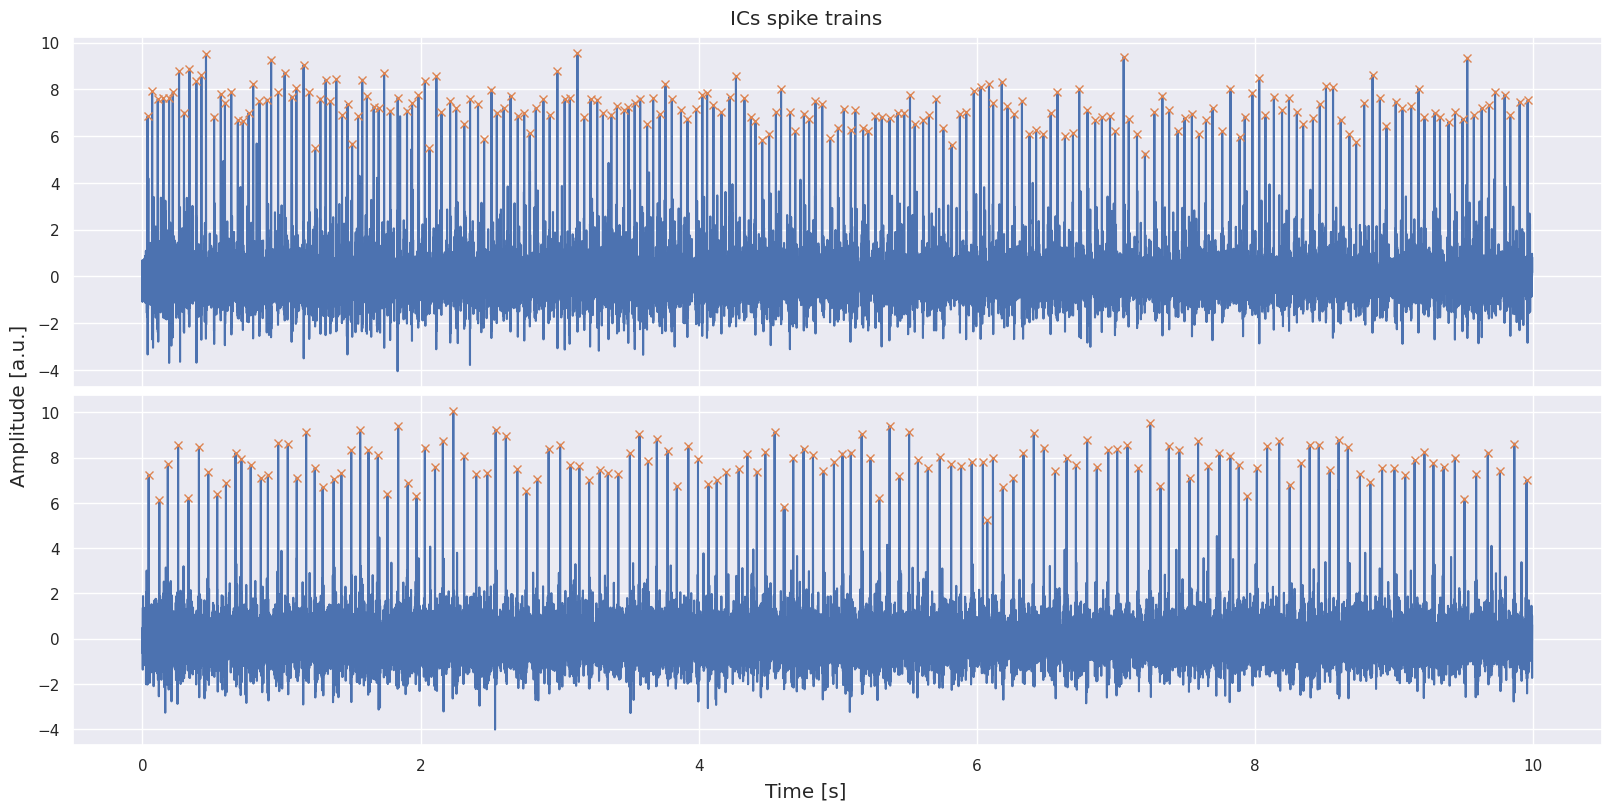

In [5]:
emgkit.plot.plot_ic_spikes(ics, spikes_t, fig_size=(16, 8))

Display the raster plot.

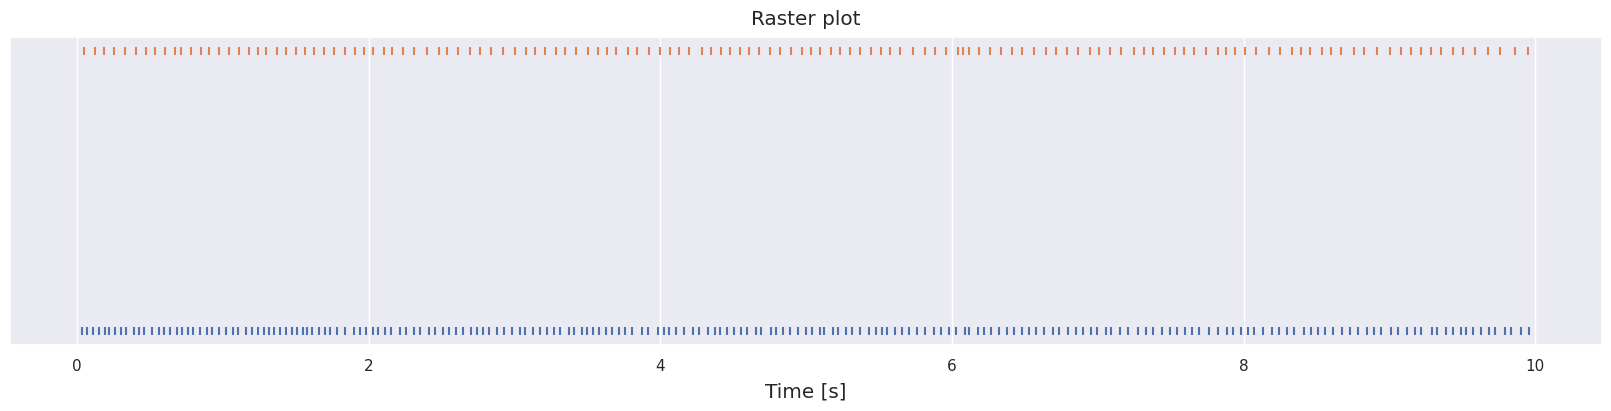

In [6]:
emgkit.plot.raster_plot(spikes_t, fig_size=(16, 4))

Display the discharge rate.

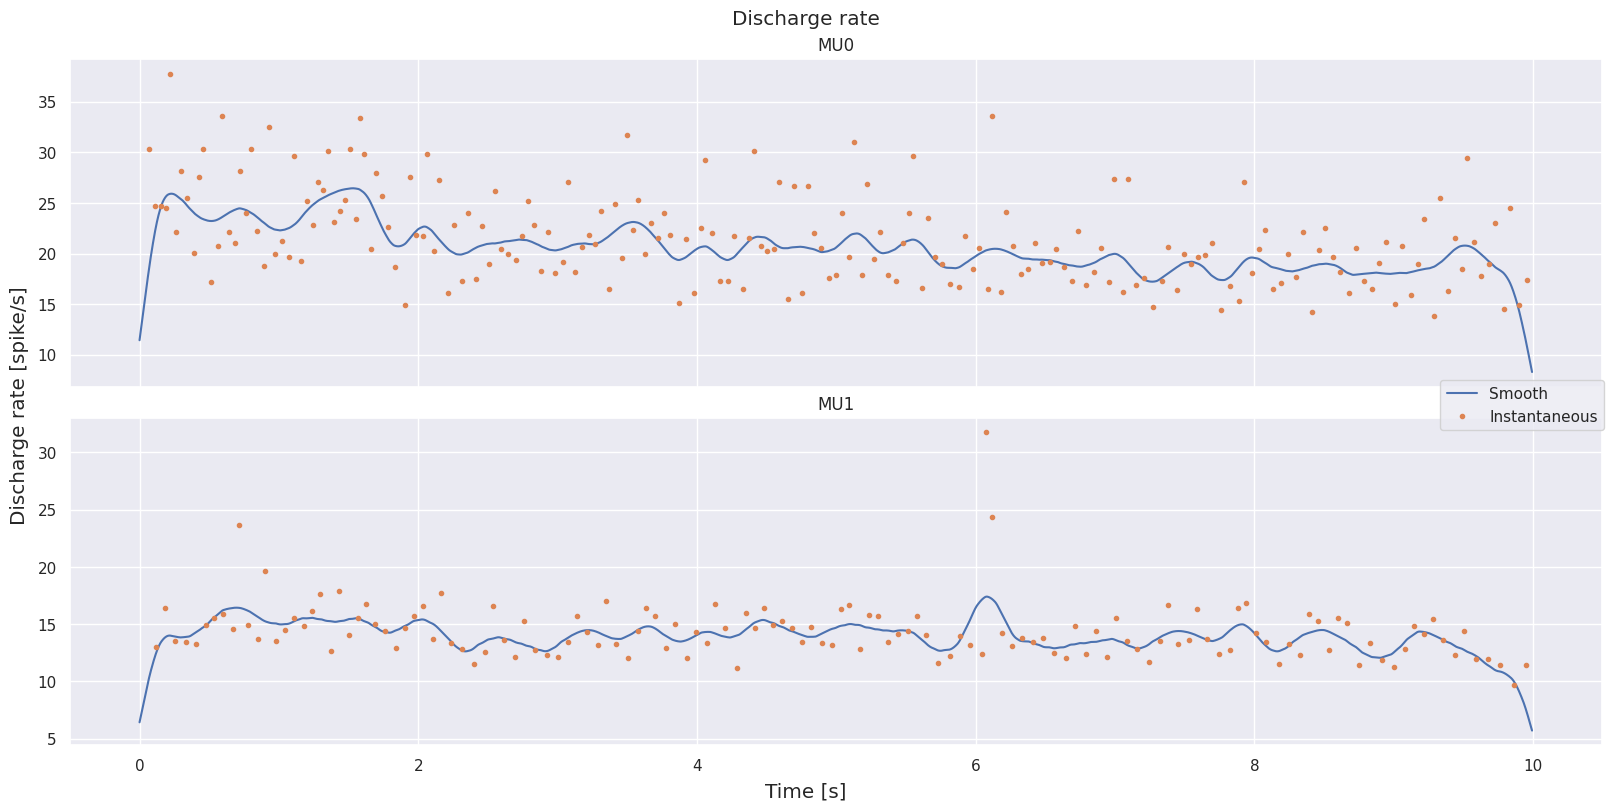

In [7]:
emgkit.plot.plot_discharges(spikes_t, ext_sig_len_s, FS, win_len_s=0.5, fig_size=(16, 8))

Compute the waveforms and plot them.

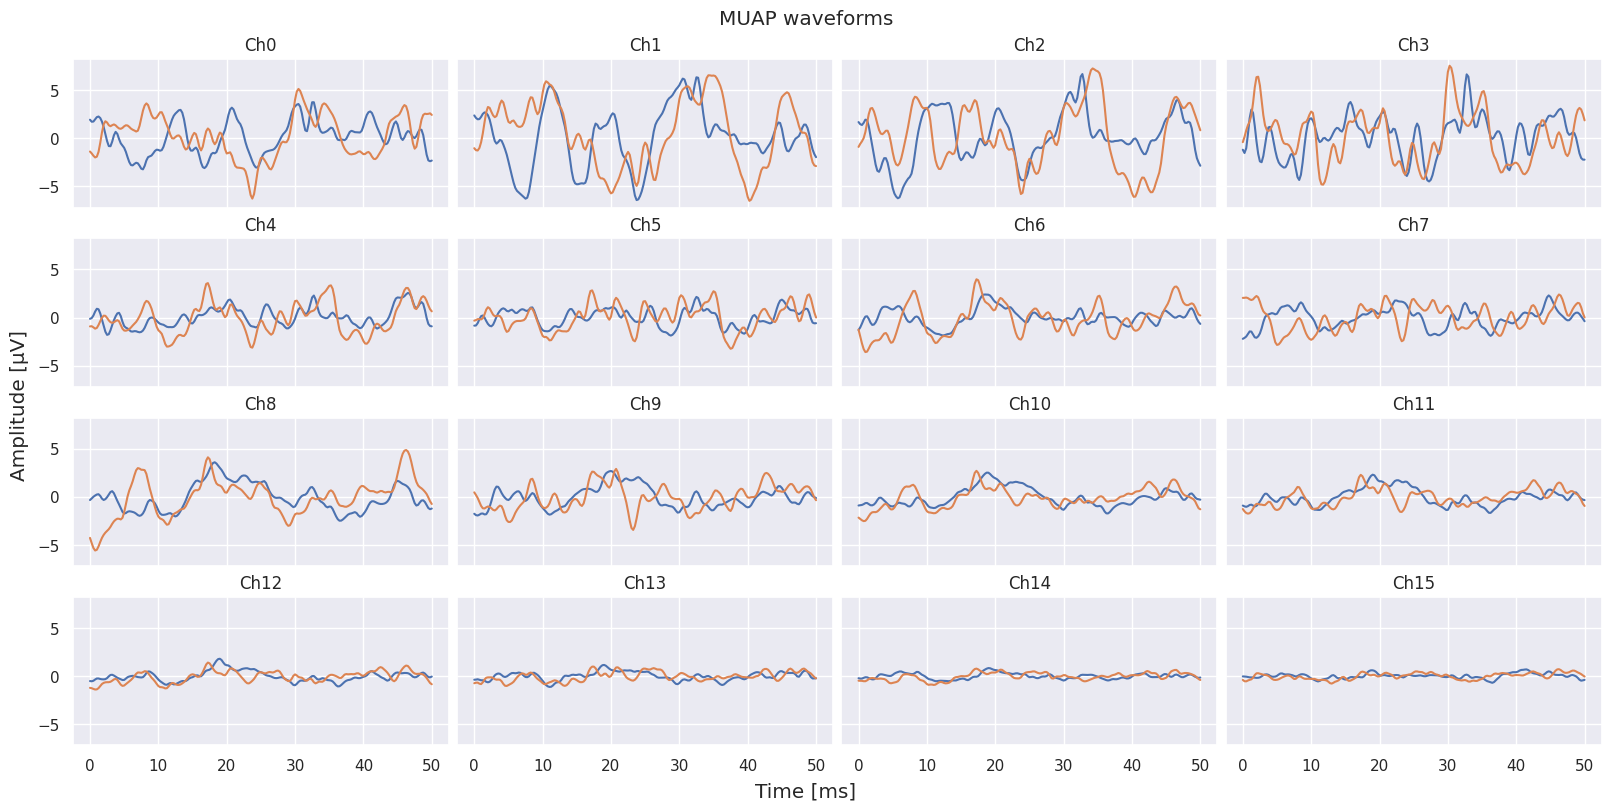

In [8]:
wfs = emgkit.utils.compute_waveforms(
    emg_flt, spikes_t, wf_radius_ms=25.0, fs=FS
)

emgkit.plot.plot_waveforms(
    wfs, fs=FS, n_cols=4, y_label="Amplitude [\u03BCV]", fig_size=(16, 8)
)